<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [ ]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:15<00:00, 15.28it/s]


Epoch 1, Loss: 0.2990


AE Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 18.34it/s]


Epoch 2, Loss: 0.1143


AE Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 18.45it/s]


Epoch 3, Loss: 0.0941


AE Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.62it/s]


Epoch 4, Loss: 0.0847


AE Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 18.54it/s]


Epoch 5, Loss: 0.0790


AE Epoch 6: 100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


Epoch 6, Loss: 0.0750


AE Epoch 7: 100%|██████████| 235/235 [00:14<00:00, 16.41it/s]


Epoch 7, Loss: 0.0719


AE Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 18.34it/s]


Epoch 8, Loss: 0.0694


AE Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.64it/s]


Epoch 9, Loss: 0.0674


AE Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 18.21it/s]


Epoch 10, Loss: 0.0656


AE Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 18.17it/s]


Epoch 11, Loss: 0.0642


AE Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 18.09it/s]


Epoch 12, Loss: 0.0630


AE Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 18.18it/s]


Epoch 13, Loss: 0.0618


AE Epoch 14: 100%|██████████| 235/235 [00:13<00:00, 17.76it/s]


Epoch 14, Loss: 0.0609


AE Epoch 15: 100%|██████████| 235/235 [00:13<00:00, 17.36it/s]


Epoch 15, Loss: 0.0600


AE Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 18.29it/s]


Epoch 16, Loss: 0.0592


AE Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 18.50it/s]


Epoch 17, Loss: 0.0585


AE Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 18.48it/s]


Epoch 18, Loss: 0.0579


AE Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.14it/s]


Epoch 19, Loss: 0.0573


AE Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 18.61it/s]

Epoch 20, Loss: 0.0567


In [ ]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:12<00:00, 18.11it/s]


[DEC] Epoch 1, Loss: 0.2095


DEC Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 19.12it/s]


[DEC] Epoch 2, Loss: 0.1811


DEC Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 18.91it/s]


[DEC] Epoch 3, Loss: 0.1700


DEC Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.87it/s]


[DEC] Epoch 4, Loss: 0.1625


DEC Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 18.76it/s]


[DEC] Epoch 5, Loss: 0.1565


DEC Epoch 6: 100%|██████████| 235/235 [00:12<00:00, 18.76it/s]


[DEC] Epoch 6, Loss: 0.1515


DEC Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 19.02it/s]


[DEC] Epoch 7, Loss: 0.1477


DEC Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 19.08it/s]


[DEC] Epoch 8, Loss: 0.1447


DEC Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.96it/s]


[DEC] Epoch 9, Loss: 0.1420


DEC Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 19.01it/s]


[DEC] Epoch 10, Loss: 0.1390


DEC Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 18.68it/s]


[DEC] Epoch 11, Loss: 0.1363


DEC Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 19.10it/s]


[DEC] Epoch 12, Loss: 0.1341


DEC Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 18.92it/s]


[DEC] Epoch 13, Loss: 0.1317


DEC Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 19.05it/s]


[DEC] Epoch 14, Loss: 0.1297


DEC Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 18.92it/s]


[DEC] Epoch 15, Loss: 0.1279


DEC Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 19.09it/s]


[DEC] Epoch 16, Loss: 0.1262


DEC Epoch 17: 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


[DEC] Epoch 17, Loss: 0.1247


DEC Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 19.03it/s]


[DEC] Epoch 18, Loss: 0.1230


DEC Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.85it/s]


[DEC] Epoch 19, Loss: 0.1215


DEC Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 18.85it/s]

[DEC] Epoch 20, Loss: 0.1200


In [ ]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7268
Davies-Bouldin Index:     0.3602
Calinski-Harabasz Index:  139736.9219


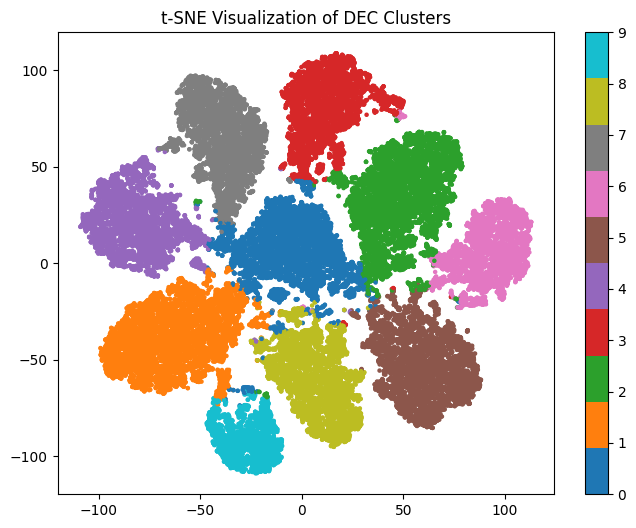

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [ ]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
